In [1]:
# Cell 1: Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Cell 2: Đọc file Xiaomi_clean.csv và xem cấu trúc dữ liệu
df = pd.read_csv('Xiaomi_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(df.head())
print("\nCác cột trong dataset:", df.columns.tolist())


            Open       High        Low      Close  Adj Close     Volume
Date                                                                   
2018-07-09  16.6  17.000000  16.000000  16.799999  16.799999  462182642
2018-07-10  17.0  19.340000  17.000000  19.000000  19.000000  534072218
2018-07-11  18.5  19.799999  18.299999  19.000000  19.000000  374721138
2018-07-12  19.4  19.700001  19.020000  19.260000  19.260000  132592630
2018-07-13  19.6  21.799999  19.520000  21.450001  21.450001  364065075

Các cột trong dataset: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [3]:
# Cell 3: Chọn cột 'Close' và chuẩn hóa với MinMaxScaler
data = df[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

print("Dữ liệu sau khi scale:\n", scaled_data[:5])


Dữ liệu sau khi scale:
 [[0.16312739]
 [0.20559844]
 [0.20559844]
 [0.21061775]
 [0.25289575]]


In [4]:
# Cell 4: Chia dữ liệu theo tỷ lệ 60/20/20
train_size = int(len(scaled_data) * 0.6)
val_size = int(len(scaled_data) * 0.2)
test_size = len(scaled_data) - train_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

print(f"Train: {len(train_data)}, Validate: {len(val_data)}, Test: {len(test_data)}")


Train: 1080, Validate: 360, Test: 360


In [6]:
# Cell 5: Hàm tạo tập dữ liệu có dạng (X, y) cho RNN
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)


In [7]:
# Cell 6: Tạo dữ liệu train/val/test có định dạng phù hợp với RNN
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape về dạng 3D [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)


X_train shape: (1019, 60, 1)


In [8]:
# Cell 7: Xây dựng mô hình LSTM RNN
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cell 8: Huấn luyện mô hình trên tập train, dùng early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[es]
)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.0054 - val_loss: 5.7563e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 9.5502e-04 - val_loss: 1.8402e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 8.2892e-04 - val_loss: 1.9852e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 7.4914e-04 - val_loss: 2.0894e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 7.7456e-04 - val_loss: 1.5285e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 6.5785e-04 - val_loss: 1.4624e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 7.0630e-04 - val_loss: 1.5454e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 5.7582e-04 - val_loss: 1.6689e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 5.7992e-04 - val_loss: 1.3838e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 5.6858e-04 - val_loss: 1.8242e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5.4747e-04 

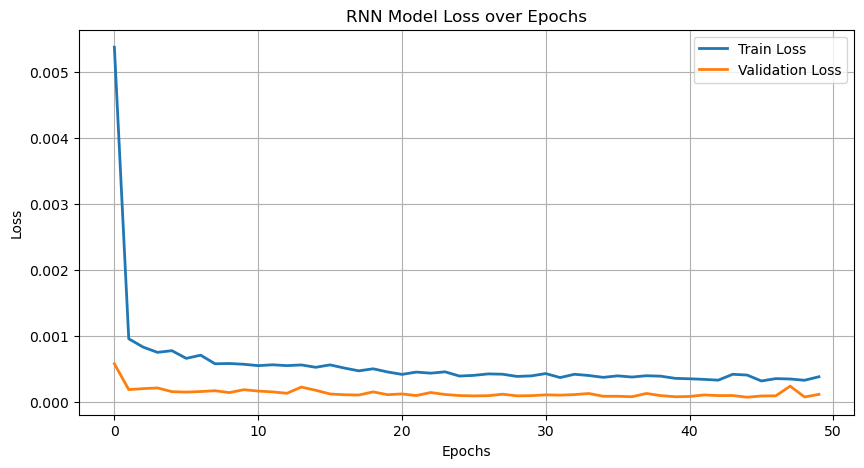

In [10]:
# Cell 9: Vẽ biểu đồ training/validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Cell 10: Dự đoán trên tập test
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 


In [12]:
# Cell 11: Tính các chỉ số MAE, MSE, RMSE, MAPE
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 2.0497
MSE: 6.6249
RMSE: 2.5739
MAPE: 4.59%


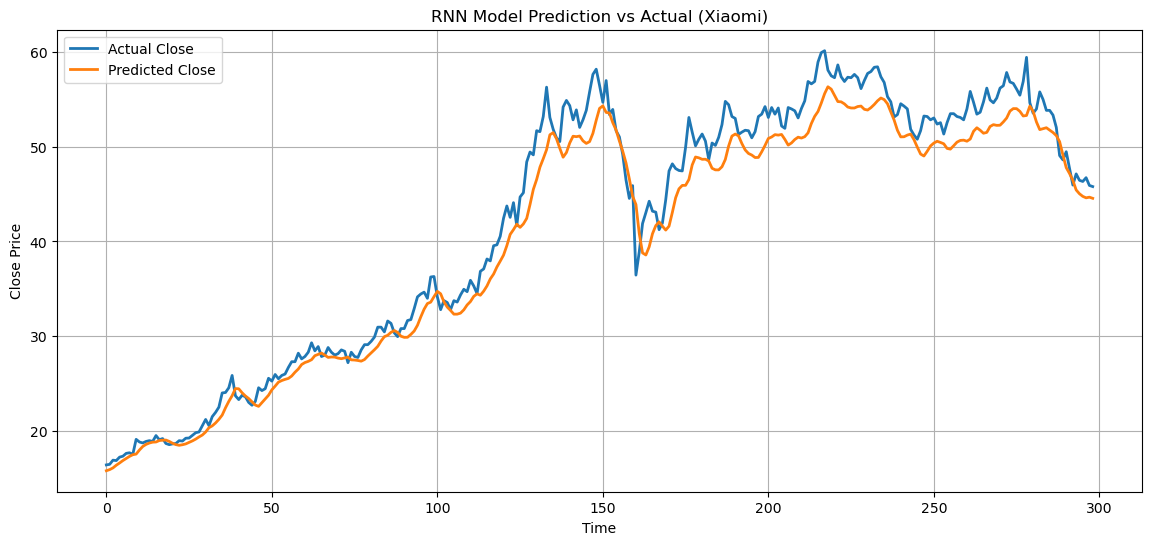

In [13]:
# Cell 12: Vẽ biểu đồ so sánh giá trị thực tế và dự đoán
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Close', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Close', linewidth=2)
plt.title('RNN Model Prediction vs Actual (Xiaomi)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Cell 13: Dự đoán 30 ngày tiếp theo (fix lỗi dimension)
last_60_days = scaled_data[-60:]
pred_input = last_60_days.reshape(1, -1, 1)
future_predictions = []

for _ in range(30):
    pred = model.predict(pred_input)
    future_predictions.append(pred[0, 0])

    # append giá trị mới (giữ nguyên shape 3D)
    new_step = np.array([[[pred[0, 0]]]])
    pred_input = np.append(pred_input[:, 1:, :], new_step, axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_inv = scaler.inverse_transform(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

In [15]:
# Cell 14: Tạo index thời gian cho 30 ngày tiếp theo
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions_inv.flatten()
}).set_index('Date')

future_df.head()


,Predicted_Close
Date,
2025-10-29,43.985310
2025-10-30,43.350098
2025-10-31,42.642807
2025-11-01,41.916954
2025-11-02,41.196514


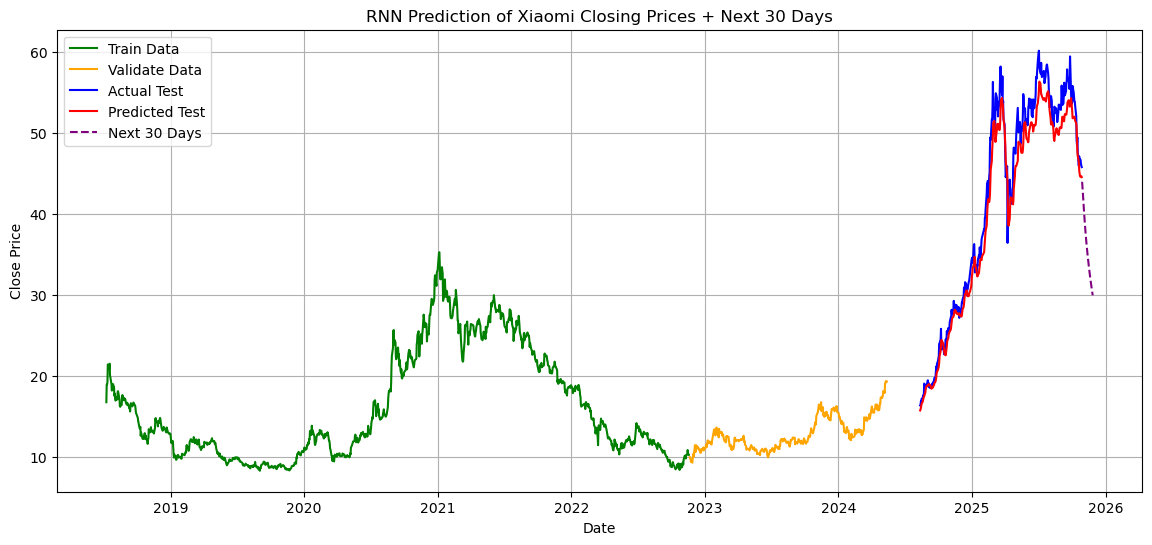

In [16]:
# Cell 15: Vẽ toàn bộ biểu đồ (Train, Test, Predict, Future)
train_plot = scaler.inverse_transform(train_data)
val_plot = scaler.inverse_transform(val_data)
test_plot = y_test_inv

plt.figure(figsize=(14,6))
plt.plot(df.index[:len(train_plot)], train_plot, label='Train Data', color='green')
plt.plot(df.index[len(train_plot):len(train_plot)+len(val_plot)], val_plot, label='Validate Data', color='orange')
plt.plot(df.index[-len(test_plot):], test_plot, label='Actual Test', color='blue')
plt.plot(df.index[-len(test_plot):], y_pred_inv, label='Predicted Test', color='red')
plt.plot(future_df.index, future_df['Predicted_Close'], label='Next 30 Days', color='purple', linestyle='--')
plt.title('RNN Prediction of Xiaomi Closing Prices + Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
